# Análisis Exploratorio de Datos - DeepSolation

Este notebook explora el dataset de señales de aisladores sísmicos para entender:
- Balance de clases (niveles de daño)
- Distribución por tipo de aislador
- Características de las señales

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 6]

# Rutas
LABELS_CSV = '../../data/nivel_damage.csv'
SIGNALS_DIR = '../../data/Signals_Raw/'

print("Setup completado")

Setup completado


## 1. Carga de Etiquetas

In [12]:
# Cargar etiquetas con estructura correcta
df_labels = pd.read_csv(LABELS_CSV)

# Renombrar columnas para mayor claridad
df_labels.columns = ['edificio', 'pasada', 'specimen_id', 'tipo', 'nivel_dano']

print(f"Total registros (edificio/pasada/aislador): {len(df_labels)}")
print(f"\nColumnas: {list(df_labels.columns)}")
print(f"\nEdificios: {df_labels['edificio'].unique()}")
print(f"Pasadas: {df_labels['pasada'].unique()}")
print(f"\nPrimeras filas:")
df_labels.head(10)

Total registros (edificio/pasada/aislador): 145

Columnas: ['edificio', 'pasada', 'specimen_id', 'tipo', 'nivel_dano']

Edificios: ['edificio_01' 'edificio_02']
Pasadas: ['pasada_01' 'pasada_02' 'pasada_03']

Primeras filas:


,edificio,pasada,specimen_id,tipo,nivel_dano
0,edificio_01,pasada_01,A1,B,N1
1,edificio_01,pasada_02,A1-2,B,N1
2,edificio_01,pasada_03,A1-3,B,N1
3,edificio_01,pasada_01,A2,B,N1
4,edificio_01,pasada_02,A2-2,B,N1
5,edificio_01,pasada_03,A2-3,B,N1
6,edificio_01,pasada_01,A3,C,N1
7,edificio_01,pasada_02,A3-2,C,N1
8,edificio_01,pasada_03,A3-3,C,N1
9,edificio_01,pasada_01,A4,B,N1


## 2. Balance de Clases

Analizamos la distribución de aisladores por nivel de daño y tipo

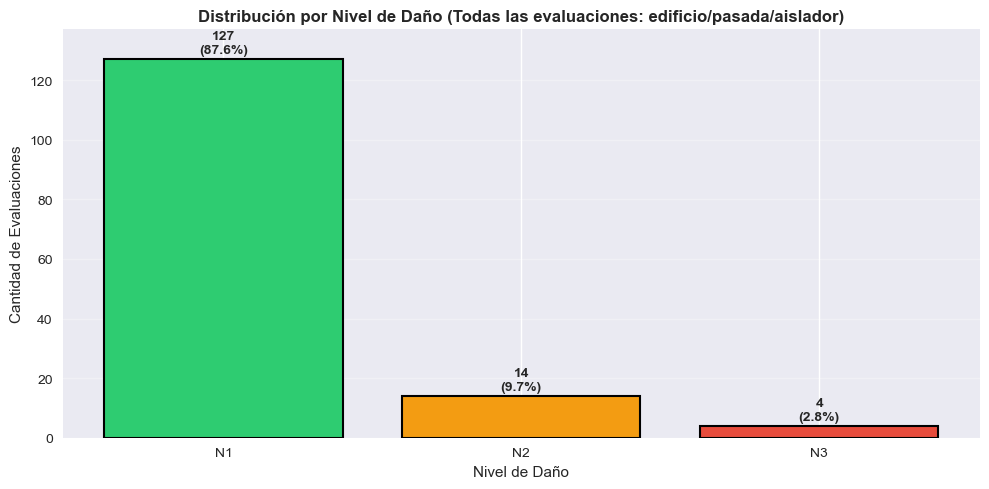

RESUMEN DE BALANCE

Total de evaluaciones: 145

Por Nivel de Daño:
  N1: 127 evaluaciones (87.6%)
  N2: 14 evaluaciones (9.7%)
  N3: 4 evaluaciones (2.8%)


In [13]:
# Distribución por nivel de daño (TODAS las evaluaciones: edificio/pasada/aislador)
fig, ax = plt.subplots(figsize=(10, 5))

nivel_counts = df_labels['nivel_dano'].value_counts().sort_index()
colors_nivel = {'N1': '#2ecc71', 'N2': '#f39c12', 'N3': '#e74c3c'}

bars = ax.bar(nivel_counts.index, nivel_counts.values, 
              color=[colors_nivel[n] for n in nivel_counts.index],
              edgecolor='black', linewidth=1.5)
ax.set_title('Distribución por Nivel de Daño (Todas las evaluaciones: edificio/pasada/aislador)', 
             fontweight='bold', fontsize=12)
ax.set_xlabel('Nivel de Daño')
ax.set_ylabel('Cantidad de Evaluaciones')

for bar, count in zip(bars, nivel_counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
            f'{count}\n({count/len(df_labels)*100:.1f}%)', 
            ha='center', fontweight='bold')

ax.set_ylim(0, max(nivel_counts.values) + 10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Resumen textual
print("="*50)
print("RESUMEN DE BALANCE")
print("="*50)
print(f"\nTotal de evaluaciones: {len(df_labels)}")
print(f"\nPor Nivel de Daño:")
for nivel in ['N1', 'N2', 'N3']:
    count = nivel_counts.get(nivel, 0)
    pct = count / len(df_labels) * 100
    print(f"  {nivel}: {count} evaluaciones ({pct:.1f}%)")

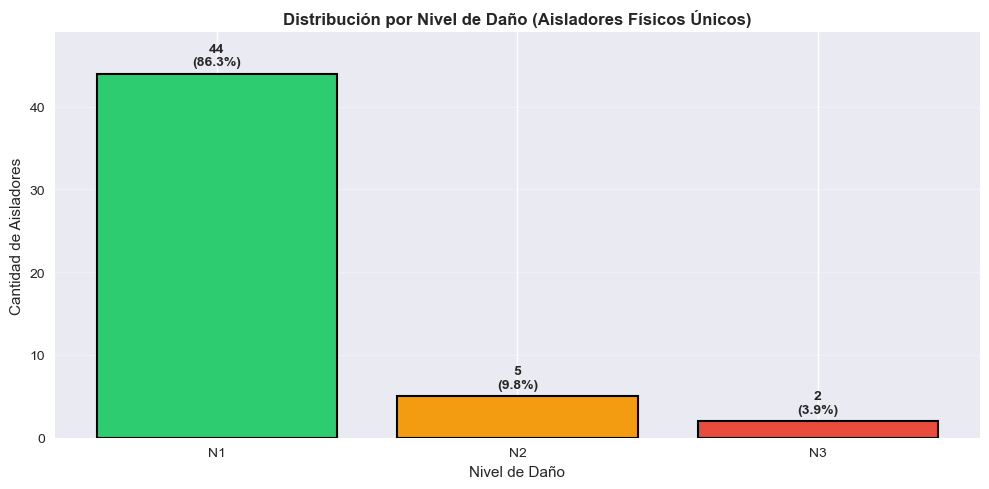

Total aisladores físicos únicos: 51

Por nivel de daño:
  N1: 44 aisladores (86.3%)
  N2: 5 aisladores (9.8%)
  N3: 2 aisladores (3.9%)

Distribución por edificio:
edificio     nivel_dano
edificio_01  N1             8
             N2             4
             N3             2
edificio_02  N1            36
             N2             1
Name: count, dtype: int64


In [14]:
# Distribución por nivel de daño - Aisladores físicos únicos
# Crear identificador de aislador base (sin sufijos -2, -3) para agrupar
df_labels['aislador_base'] = df_labels['specimen_id'].str.replace(r'-[23]$', '', regex=True)

# Agrupar por edificio y aislador_base, tomando la primera evaluación
df_unique = df_labels.groupby(['edificio', 'aislador_base']).first().reset_index()

fig, ax = plt.subplots(figsize=(10, 5))

nivel_counts_unique = df_unique['nivel_dano'].value_counts().sort_index()
bars = ax.bar(nivel_counts_unique.index, nivel_counts_unique.values, 
              color=[colors_nivel[n] for n in nivel_counts_unique.index],
              edgecolor='black', linewidth=1.5)
ax.set_title('Distribución por Nivel de Daño (Aisladores Físicos Únicos)', fontweight='bold', fontsize=12)
ax.set_xlabel('Nivel de Daño')
ax.set_ylabel('Cantidad de Aisladores')

for bar, count in zip(bars, nivel_counts_unique.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            f'{count}\n({count/len(df_unique)*100:.1f}%)', 
            ha='center', fontweight='bold')

ax.set_ylim(0, max(nivel_counts_unique.values) + 5)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Total aisladores físicos únicos: {len(df_unique)}")
print(f"\nPor nivel de daño:")
for nivel in ['N1', 'N2', 'N3']:
    count = nivel_counts_unique.get(nivel, 0)
    print(f"  {nivel}: {count} aisladores ({count/len(df_unique)*100:.1f}%)")

print(f"\nDistribución por edificio:")
print(df_unique.groupby('edificio')['nivel_dano'].value_counts().sort_index())

## 3. Exploración de Archivos de Señales

Verificamos la estructura de los archivos de señales disponibles.

In [15]:
# Explorar archivos de señales usando la estructura jerárquica
# Estructura: Signals_Raw/edificio_XX/pasada_YY/specimen_id/completo_S1.txt
# NOTA: Los nombres de carpetas coinciden exactamente con specimen_id del CSV (incluyen sufijos -2, -3)

signal_info = []
missing_files = []

for idx, row in df_labels.iterrows():
    edificio = row['edificio']
    pasada = row['pasada']
    specimen_id = row['specimen_id']  # Usar nombre completo (con sufijos si los tiene)
    nivel_dano = row['nivel_dano']
    tipo = row['tipo']
    
    # Construir ruta al directorio del aislador (usar specimen_id completo)
    aislador_dir = os.path.join(SIGNALS_DIR, edificio, pasada, specimen_id)
    
    # Verificar si existe el directorio
    if not os.path.exists(aislador_dir):
        missing_files.append({
            'edificio': edificio,
            'pasada': pasada,
            'specimen_id': specimen_id
        })
        continue
    
    # Buscar archivos S1 y S2
    for sensor in ['S1', 'S2']:
        # Buscar archivo que contenga el sensor
        files = [f for f in os.listdir(aislador_dir) if sensor in f and f.endswith('.txt')]
        
        if files:
            file_path = os.path.join(aislador_dir, files[0])
            # Leer archivo para obtener número de muestras
            df_temp = pd.read_csv(file_path, sep='\s+', engine='python')
            
            signal_info.append({
                'edificio': edificio,
                'pasada': pasada,
                'specimen_id': specimen_id,
                'sensor': sensor,
                'n_samples': len(df_temp),
                'nivel_dano': nivel_dano,
                'tipo': tipo,
                'file': files[0]
            })

df_signals = pd.DataFrame(signal_info)

print(f"Total archivos de señales encontrados: {len(df_signals)}")
print(f"Total registros en CSV: {len(df_labels)}")
print(f"Registros esperados (CSV × 2 sensores): {len(df_labels) * 2}")
print(f"Sensores por registro: {df_signals.groupby(['edificio', 'pasada', 'specimen_id'])['sensor'].nunique().mean():.1f}")

if missing_files:
    print(f"\n⚠️  Registros sin archivos: {len(missing_files)}")
    print("Primeros registros faltantes:")
    for mf in missing_files[:5]:
        print(f"  {mf['edificio']}/{mf['pasada']}/{mf['specimen_id']}")
else:
    print("\n✓ Todos los archivos fueron encontrados")

print(f"\nDistribución de señales por edificio:")
print(df_signals.groupby('edificio').size())
print(f"\nDistribución de señales por nivel de daño:")
print(df_signals.groupby('nivel_dano').size())

Total archivos de señales encontrados: 290
Total registros en CSV: 145
Registros esperados (CSV × 2 sensores): 290
Sensores por registro: 2.0

✓ Todos los archivos fueron encontrados

Distribución de señales por edificio:
edificio
edificio_01     68
edificio_02    222
dtype: int64

Distribución de señales por nivel de daño:
nivel_dano
N1    254
N2     28
N3      8
dtype: int64


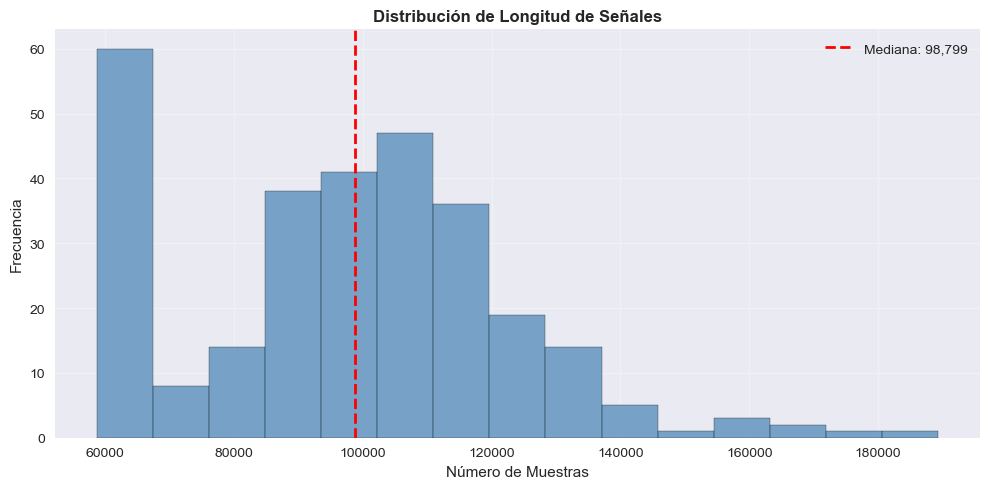

Estadísticas de longitud de señales:
  Mínimo: 58,700 muestras
  Máximo: 189,299 muestras
  Mediana: 98,799 muestras


In [16]:
# Visualizar distribución de longitudes de señales
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(df_signals['n_samples'], bins=15, color='steelblue', 
        edgecolor='black', alpha=0.7)
ax.axvline(df_signals['n_samples'].median(), color='red', 
           linestyle='--', linewidth=2, label=f"Mediana: {df_signals['n_samples'].median():,.0f}")
ax.set_title('Distribución de Longitud de Señales', fontweight='bold')
ax.set_xlabel('Número de Muestras')
ax.set_ylabel('Frecuencia')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Estadísticas de longitud de señales:")
print(f"  Mínimo: {df_signals['n_samples'].min():,} muestras")
print(f"  Máximo: {df_signals['n_samples'].max():,} muestras")
print(f"  Mediana: {df_signals['n_samples'].median():,.0f} muestras")

## 4. Visualización de Señales de Ejemplo

Mostramos una señal representativa de cada nivel de daño.

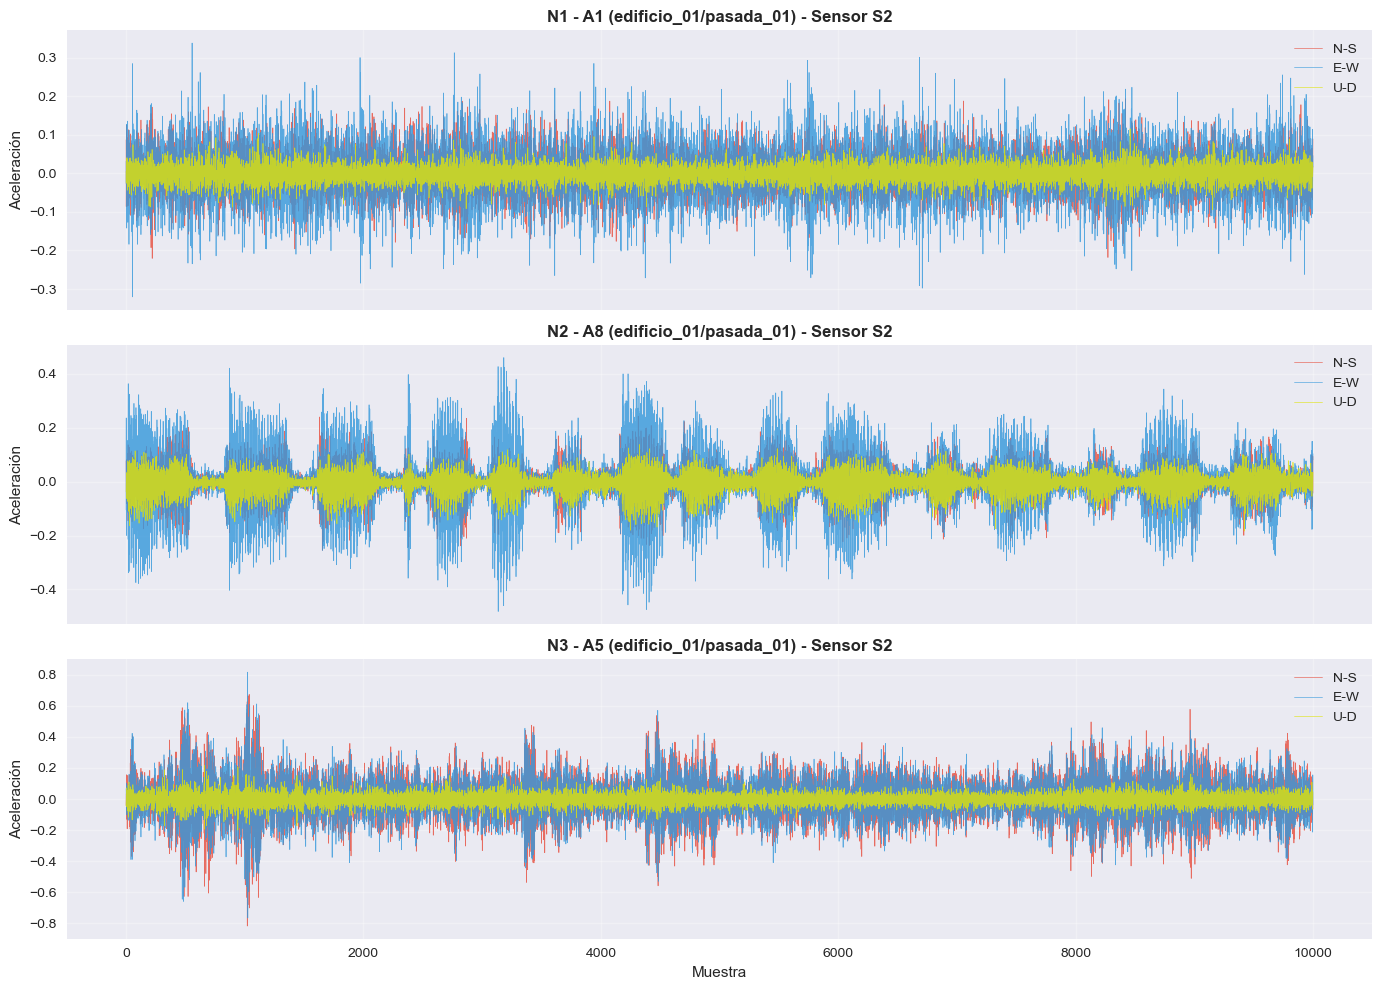


Aisladores mostrados:
  N1: A1 - edificio_01/pasada_01 (Tipo B)
  N2: A8 - edificio_01/pasada_01 (Tipo B)
  N3: A5 - edificio_01/pasada_01 (Tipo A)


In [17]:
# Seleccionar un ejemplo de cada nivel de daño (de la primera ocurrencia)
sample_rows = {}
for nivel in ['N1', 'N2', 'N3']:
    matching = df_labels[df_labels['nivel_dano'] == nivel]
    if len(matching) > 0:
        sample_rows[nivel] = matching.iloc[0]

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
colors_axis = {'N-S': '#e74c3c', 'E-W': '#3498db', 'U-D': "#dfe309"}

for idx, (nivel, row) in enumerate(sample_rows.items()):
    edificio = row['edificio']
    pasada = row['pasada']
    specimen_id = row['specimen_id']  # Usar nombre completo (con sufijos)
    tipo = row['tipo']
    
    # Construir ruta al archivo S2 (respuesta del aislador)
    aislador_dir = os.path.join(SIGNALS_DIR, edificio, pasada, specimen_id)
    s2_files = [f for f in os.listdir(aislador_dir) if 'S2' in f and f.endswith('.txt')]
    
    if not s2_files:
        print(f"⚠️  No se encontró archivo S2 para {specimen_id}")
        continue
    
    # Leer señal
    signal_path = os.path.join(aislador_dir, s2_files[0])
    df_signal = pd.read_csv(signal_path, sep='\s+', engine='python')
    
    # Tomar primeras 10000 muestras para visualización
    df_plot = df_signal.head(10000)
    
    # Plotear cada eje
    for col, color in colors_axis.items():
        if col in df_plot.columns:
            axes[idx].plot(df_plot[col].values, label=col, color=color, alpha=0.8, linewidth=0.5)
    
    axes[idx].set_title(f'{nivel} - {specimen_id} ({edificio}/{pasada}) - Sensor S2', fontweight='bold')
    axes[idx].set_ylabel('Aceleración')
    axes[idx].legend(loc='upper right')
    axes[idx].grid(True, alpha=0.3)

axes[2].set_xlabel('Muestra')
plt.tight_layout()
plt.show()

print(f"\nAisladores mostrados:")
for nivel, row in sample_rows.items():
    print(f"  {nivel}: {row['specimen_id']} - {row['edificio']}/{row['pasada']} (Tipo {row['tipo']})")

## 5. Conclusiones del EDA

### Hallazgos principales:

1. **Desbalance de clases SEVERO**: 
   - N1: ~87% (127 evaluaciones)
   - N2: ~10% (14 evaluaciones)
   - N3: ~3% (solo 4 evaluaciones) ⚠️ CRÍTICO

2. **Múltiples evaluaciones por aislador**:
   - Los datos incluyen diferentes pasadas de evaluación (pasada_01, pasada_02, pasada_03)
   - Algunos aisladores tienen múltiples evaluaciones por diferentes expertos o momentos
   - Se detectaron **inconsistencias en etiquetado** entre pasadas del mismo aislador (ej: A2, A23 del edificio_02)
   - **IMPORTANTE**: Esta variabilidad NO es ruido - demuestra la **subjetividad del criterio experto**

3. **Estructura del dataset**:
   - 2 edificios con diferentes características
   - edificio_01: Mayor variabilidad en niveles de daño (incluye N3)
   - edificio_02: Predominantemente N1 (aisladores sanos)
   - Señales organizadas jerárquicamente: edificio/pasada/aislador/sensor

4. **Características de las señales**:
   - Longitud variable: ~58,700 a ~170,000 muestras
   - 2 sensores por aislador (S1 y S2)
   - 3 ejes por señal: N-S, E-W, U-D
   - Requieren normalización/estandarización

### Implicaciones para el modelado:

1. **Desbalance de clases**: Requiere técnicas de balanceo
   - SMOTE, data augmentation, o VAE para generar muestras sintéticas
   - Pesos en función de pérdida
   - Especial atención a N3 (solo 4 muestras)

2. **Variabilidad de expertos como motivación**:
   - Las inconsistencias en etiquetado justifican un sistema automatizado
   - Un modelo de DL puede ofrecer criterios **más consistentes** que evaluación humana
   - Usar **autoencoders** para aprender de las señales físicas (no de etiquetas subjetivas)

3. **Estrategia de datos**:
   - **Usar TODAS las evaluaciones** (no solo aisladores únicos)
   - Cada evaluación es una observación independiente con valor
   - Considerar arquitectura de dos etapas: Autoencoder + Clasificador

4. **Preprocesamiento necesario**:
   - Normalización de longitud de señales
   - Estandarización de amplitudes
   - Considerar features en frecuencia (FFT, wavelets)